In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, precision_recall_curve
import numpy as np

In [57]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [58]:
%tensorboard --logdir /content/runs

Reusing TensorBoard on port 6007 (pid 18336), started 0:35:04 ago. (Use '!kill 18336' to kill it.)

In [59]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values
])

# Download and load USPS dataset
train_dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.USPS(root='./data', train=False, download=True, transform=transform)

# Split train dataset into train and validation sets (you can use any other method for splitting)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoader for train, validation, and test sets
batch_size = 64  # Set the batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # x = torch.relu(self.conv4(x))
        # x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(2048, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # x = torch.relu(self.conv3(x))
        # x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # x = torch.relu(self.conv4(x))
        # x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [61]:
import torch.optim as optim

mlp_model = MLP()
cnn_model = CNN()
cnn_model2 = CNN2()
cnn_model3 = CNN3()

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer_mlp = optim.SGD(mlp_model.parameters(), lr=0.01)
optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.01)

In [62]:
def train(model, optimizer, criterion, train_loader, val_loader, writer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [63]:
def evaluate(model, criterion, data_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).numpy())

    accuracy = correct / total
    conf_matrix = confusion_matrix(y_true, np.argmax(y_scores, axis=1))
    precision = precision_score(y_true, np.argmax(y_scores, axis=1), average='weighted')
    recall = recall_score(y_true, np.argmax(y_scores, axis=1), average='weighted')

    return accuracy, recall, precision, conf_matrix, y_true, y_scores


In [64]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_scores, writer):
    precision = dict()
    recall = dict()
    n_classes = len(np.unique(y_true))

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve([1 if label == i else 0 for label in y_true], [score[i] for score in y_scores])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='Class {}'.format(i))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    if writer:
        writer.add_figure('Precision-Recall Curve', plt.gcf())


Epoch [1/5], Loss: 2.2340, Validation Accuracy: 0.3338
Epoch [2/5], Loss: 2.0293, Validation Accuracy: 0.3585
Epoch [3/5], Loss: 1.6896, Validation Accuracy: 0.5326
Epoch [4/5], Loss: 1.3246, Validation Accuracy: 0.6929
Epoch [5/5], Loss: 1.0182, Validation Accuracy: 0.7759
Epoch [1/5], Loss: 2.3039, Validation Accuracy: 0.1035
Epoch [2/5], Loss: 2.2922, Validation Accuracy: 0.1666
Epoch [3/5], Loss: 2.2824, Validation Accuracy: 0.1666
Epoch [4/5], Loss: 2.2734, Validation Accuracy: 0.1666
Epoch [5/5], Loss: 2.2659, Validation Accuracy: 0.1666
Epoch [1/5], Loss: 2.3197, Validation Accuracy: 0.0864
Epoch [2/5], Loss: 2.3195, Validation Accuracy: 0.0864
Epoch [3/5], Loss: 2.3191, Validation Accuracy: 0.0864
Epoch [4/5], Loss: 2.3193, Validation Accuracy: 0.0864
Epoch [5/5], Loss: 2.3193, Validation Accuracy: 0.0864
Epoch [1/5], Loss: 2.3208, Validation Accuracy: 0.0795
Epoch [2/5], Loss: 2.3204, Validation Accuracy: 0.0795
Epoch [3/5], Loss: 2.3209, Validation Accuracy: 0.0795
Epoch [4/5

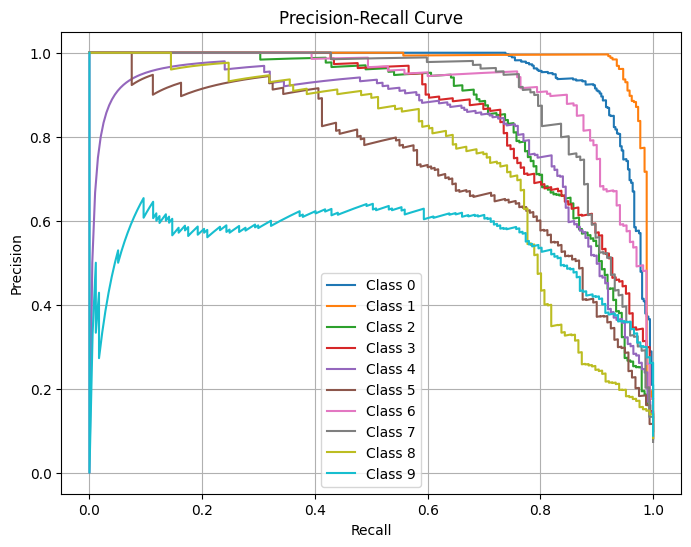

c:\Users\Manish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Manish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Manish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


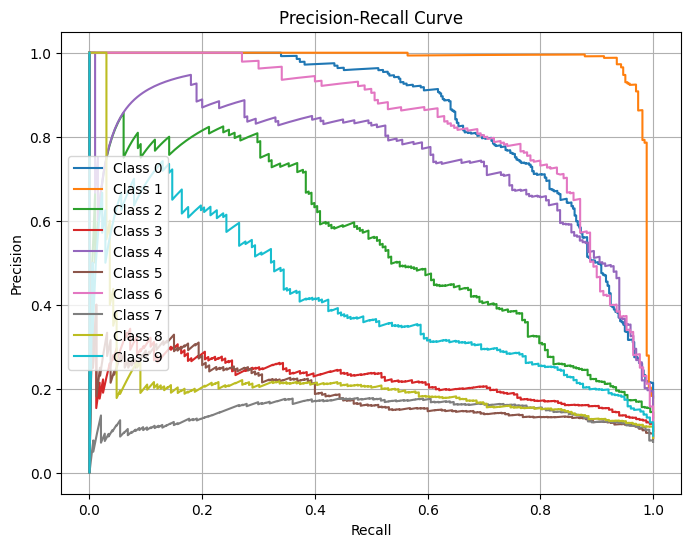

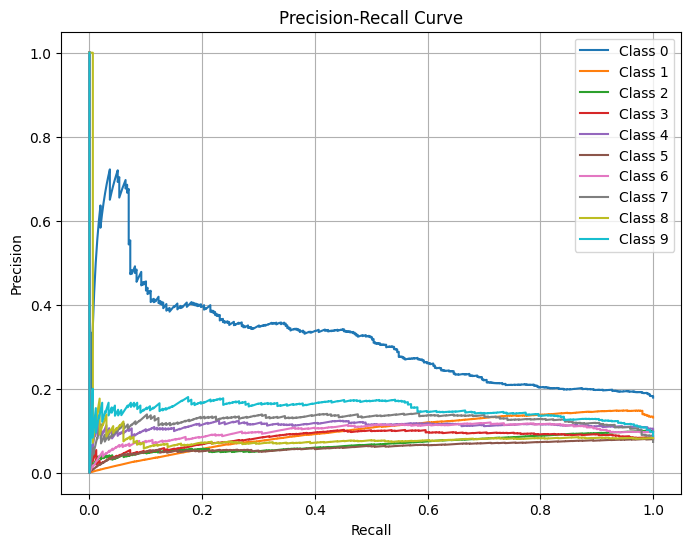

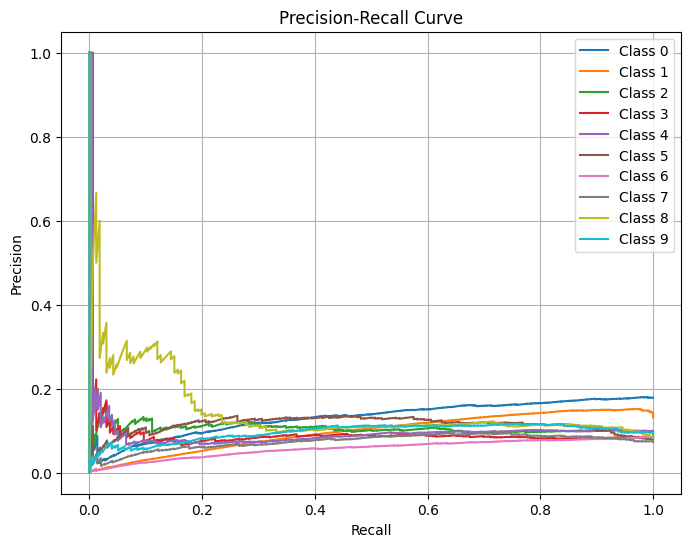

MLP Accuracy: 0.71898355754858
MLP Recall: 0.71898355754858
MLP Precision: 0.737635235951241
MLP Confusion Matrix:
[[343   0   2   1   2   2   8   1   0   0]
 [  0 256   0   2   0   0   5   1   0   0]
 [ 20   9 142   5   8   0  11   3   0   0]
 [  9   0   5 140   2   8   0   2   0   0]
 [  2  22  12   0 120   0   2   6   0  36]
 [ 47   1   3  24   4  66   9   4   2   0]
 [ 13   3   5   0   2   1 146   0   0   0]
 [  0   3   1   1   1   0   0 139   1   1]
 [ 11  17  29  23  15   6   3  20  39   3]
 [  0   9   0   0  14   0   0 102   0  52]]
CNN Accuracy: 0.17887394120577976
CNN Recall: 0.17887394120577976
CNN Precision: 0.03199588684248876
CNN Confusion Matrix:
[[359   0   0   0   0   0   0   0   0   0]
 [264   0   0   0   0   0   0   0   0   0]
 [198   0   0   0   0   0   0   0   0   0]
 [166   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [160   0   0   0   0   0   0   0   0   0]
 [170   0   0   0   0   0   0   0   0   0]
 [147   0   0   0   0   0   0 

In [65]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Initialize TensorBoard writer
writer = SummaryWriter()

# Train MLP model
train(mlp_model, optimizer_mlp, criterion, train_loader, val_loader, writer)

# Train CNN model
train(cnn_model, optimizer_cnn, criterion, train_loader, val_loader, writer)
train(cnn_model2, optimizer_cnn, criterion, train_loader, val_loader, writer)
train(cnn_model3, optimizer_cnn, criterion, train_loader, val_loader, writer)

# Evaluate MLP model
mlp_accuracy, mlp_recall, mlp_precision, mlp_conf_matrix, y_true, y_scores = evaluate(mlp_model, criterion, test_loader)

# Plot precision-recall curve
plot_precision_recall_curve(y_true, y_scores, writer)

# Evaluate CNN model
cnn_accuracy, cnn_recall, cnn_precision, cnn_conf_matrix, y_true, y_scores = evaluate(cnn_model, criterion, test_loader)
cnn_accuracy2, cnn_recall2, cnn_precision2, cnn_conf_matrix2, y_true2, y_scores2 = evaluate(cnn_model2, criterion, test_loader)
cnn_accuracy3, cnn_recall3, cnn_precision3, cnn_conf_matrix3, y_true3, y_scores3 = evaluate(cnn_model3, criterion, test_loader)

# Plot precision-recall curve
plot_precision_recall_curve(y_true, y_scores, writer)
plot_precision_recall_curve(y_true2, y_scores2, writer)
plot_precision_recall_curve(y_true3, y_scores3, writer)

# Close TensorBoard writer
writer.close()

# Display results
print("MLP Accuracy:", mlp_accuracy)
print("MLP Recall:", mlp_recall)
print("MLP Precision:", mlp_precision)
print("MLP Confusion Matrix:")
print(mlp_conf_matrix)

print("CNN Accuracy:", cnn_accuracy)
print("CNN Recall:", cnn_recall)
print("CNN Precision:", cnn_precision)
print("CNN Confusion Matrix:")
print(cnn_conf_matrix)

print("CNN Accuracy2:", cnn_accuracy2)
print("CNN Recall2:", cnn_recall2)
print("CNN Precision2:", cnn_precision2)
print("CNN Confusion Matrix2:")
print(cnn_conf_matrix2)

print("CNN Accuracy3:", cnn_accuracy3)
print("CNN Recall3:", cnn_recall3)
print("CNN Precision3:", cnn_precision3)
print("CNN Confusion Matrix3:")
print(cnn_conf_matrix3)